In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
class DataGenerator:
    def __init__(
        self,
        choice_probability: list[float] = [0.75, 0.2, 0.05],
        alternative_probability: list[float] = None,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.choice_probability = choice_probability
        self.alternative_probability = alternative_probability
        self.total_panel = total_panel
        self.choices = np.fromiter(range(len(choice_probability)), dtype=int)
        self.is_treatment_group = not control_group
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4, use_alternative_for_n_terms: int = None):

        if use_alternative_for_n_terms is not None and use_alternative_for_n_terms > 0:
            mediated_choices = np.random.choice(a = self.choices, size = (n_samples, use_alternative_for_n_terms), p = self.alternative_probability)
            non_mediated_choices = np.random.choice(a = self.choices, size = (n_samples, self.total_panel - use_alternative_for_n_terms), p = self.choice_probability)
            full_panel_data = np.hstack([mediated_choices, non_mediated_choices])
        else:
            full_panel_data = np.random.choice(a = self.choices, size = (n_samples, self.total_panel), p = self.choice_probability)
            
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [3]:
c_gen = DataGenerator(
    choice_probability= [0.9, 0.1],
    total_panel = 52,
    control_group = True
)
c_gen.generate_data(n_samples=10, n_surrogates=4)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0,1,0,0,6,0
1,0,0,0,0,3,0
2,0,0,0,0,8,0
3,0,0,0,0,3,0
4,1,0,0,0,6,0
5,0,0,0,1,5,0
6,0,0,0,1,4,0
7,0,0,0,0,5,0
8,0,0,0,0,3,0
9,1,0,0,0,5,0


In [6]:
t_gen = DataGenerator(
    choice_probability=[0.9, 0.1],
    alternative_probability=[0.8, 0.2],
    total_panel = 52,
    control_group = False
)
t_gen.generate_data(n_samples=10, n_surrogates=4, use_alternative_for_n_terms=5)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0,0,0,0,6,1
1,1,0,0,0,4,1
2,0,0,0,0,7,1
3,0,0,0,0,6,1
4,0,0,0,1,9,1
5,0,1,1,0,3,1
6,0,0,0,1,9,1
7,0,0,0,0,4,1
8,0,0,1,0,5,1
9,0,0,0,0,6,1


In [3]:
def surrogate_index_model_experiment(
        n_surrogate_list:list = [4],
        sample_size = 1000,
        control_probabilities = [0.75, 0.2, 0.05],
        treatment_probabilities = [0.74, 0.205, 0.055],
        mediation_term_list: list = None
    ) -> tuple[float, list[float]]:
    control_data = (
        DataGenerator(
            choice_probability = control_probabilities,
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    
    predicted_experiment_treatment_effects = list()

    if mediation_term_list is not None:
        space = zip(n_surrogate_list, mediation_term_list)
    else:
        space = zip(n_surrogate_list, [None] * len(n_surrogate_list))

    for values in space:
        n_surrogates, mediation_terms = values

        treatment_data = (
            DataGenerator(
                choice_probability = control_probabilities,
                alternative_probability = treatment_probabilities,
                control_group=False
            )
            .generate_data(
                n_surrogates=max(n_surrogate_list),
                n_samples=sample_size,
                use_alternative_for_n_terms=mediation_terms
            )
        )

        experiment_data = pd.concat([control_data, treatment_data])

        train_data, test_data = train_test_split(experiment_data, test_size=0.5)

        observed_experiment_analysis = (
            smf.ols(
                formula = 'unit_total ~ 1 + treatment',
                data = test_data
            )
            .fit()
        )
        observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

        surrogate_index_model = (
            smf.ols(
                formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
                data = train_data
            )
            .fit()
        )
        predicted_test_data = (
            test_data
            .assign(
                predicted_unit_total = surrogate_index_model.predict(test_data)
            )
        )

        predicted_experiment_analysis = (
            smf.ols(
                formula = 'predicted_unit_total ~ 1 + treatment',
                data = predicted_test_data
            )
            .fit()
        )
        predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']
        predicted_experiment_treatment_effects.append(predicted_experiment_treatment_effect)



    return observed_experiment_treatment_effect, predicted_experiment_treatment_effects


# Same results as in _

In [6]:
observed_effects = list()
predicted_effects = list()
n_surrogate_list = [4, 8, 32, 51]
mediation_term_list = [52, 52, 52, 52]
for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(
        n_surrogate_list=n_surrogate_list,
        mediation_term_list=mediation_term_list
    )
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)
predicted_effects = pd.DataFrame(
    data = np.array(predicted_effects),
    columns = n_surrogate_list
)

Text(0.5, 0, 'Treatment Effect')

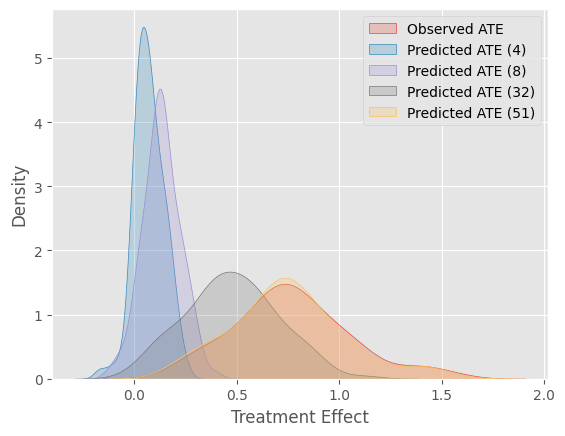

In [7]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
for n_surrogates in n_surrogate_list:
    sns.kdeplot(predicted_effects.loc[:, n_surrogates], label=f'Predicted ATE ({n_surrogates})', ax = ax, fill = True)

ax.legend()
ax.set_xlabel('Treatment Effect')

# Change results

In [10]:
observed_effects = list()
predicted_effects = list()
n_surrogate_list = [4, 8, 12, 16, 32]
mediation_term_list = [16, 16, 16, 16, 16]
for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(
        n_surrogate_list=n_surrogate_list,
        mediation_term_list=mediation_term_list
    )
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)
predicted_effects = pd.DataFrame(
    data = np.array(predicted_effects),
    columns = n_surrogate_list
)

Text(0.5, 0, 'Treatment Effect')

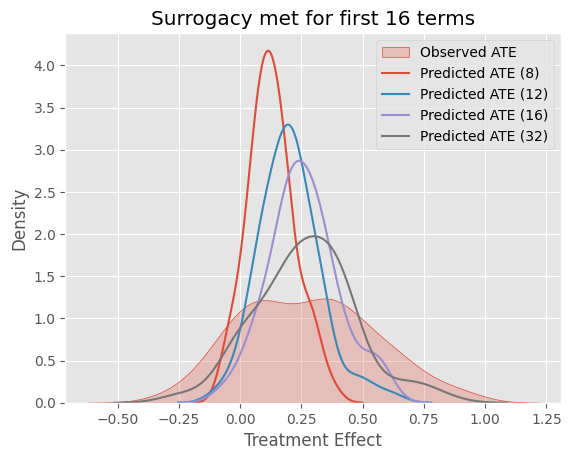

In [14]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
for n_surrogates in n_surrogate_list[1:]:
    sns.kdeplot(predicted_effects.loc[:, n_surrogates], label=f'Predicted ATE ({n_surrogates})', ax = ax, fill = False)

ax.legend()
ax.set_title('Surrogacy met for first 16 terms')
ax.set_xlabel('Treatment Effect')